# Mixed & Labelled Corpus

In [ ]:
! pip install Empath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 868.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Empath: filename=empath-0.89-py3-none-any.whl size=57800 sha256=dad71df273238d3d23bb7af1cbff69a13562cd9084f23970bd91edf7fd8f6569
  Stored in directory: /root/.cache/pip/wheels/92/b3/83/9eb2c6199881e2385a59d99bd911363475060ebeb4bdb27242
Successfully built Empath


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from scipy import sparse
from empath import Empath

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Baseline accuracy: 0.6285714285714286


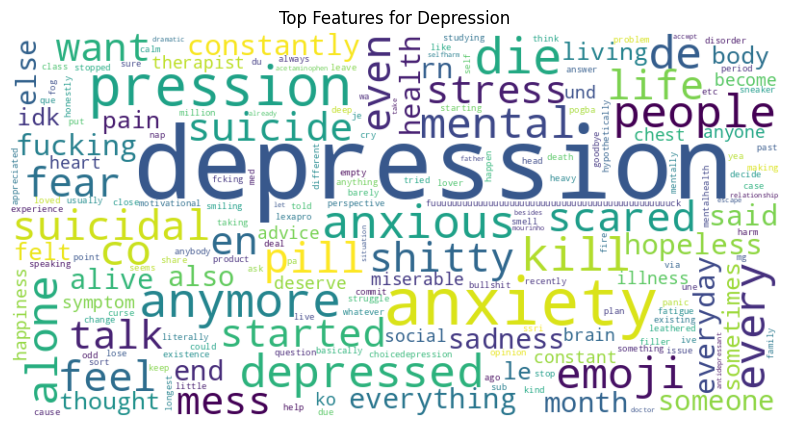


Cross-validation accuracy: [0.96571429 0.96571429 0.97142857 0.96685714]

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       880
           1       0.98      0.93      0.95       520

    accuracy                           0.97      1400
   macro avg       0.97      0.96      0.96      1400
weighted avg       0.97      0.97      0.97      1400

Baseline accuracy: 0.4914586070959264


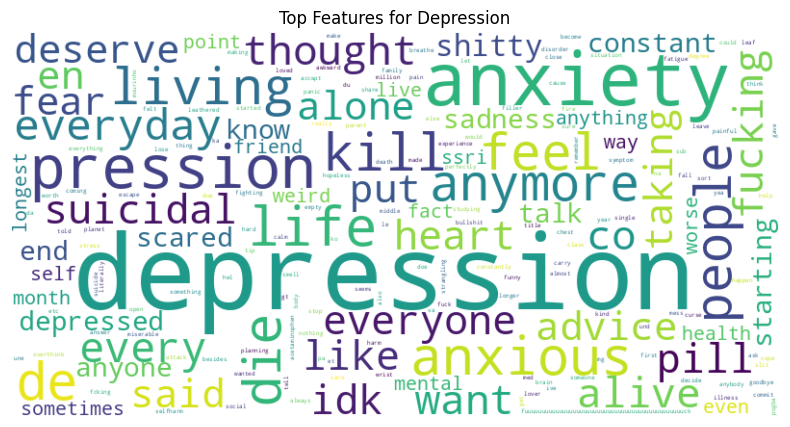


Cross-validation accuracy: [0.94532072 0.95268139 0.95688749 0.94631579]

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       374
           1       0.98      0.93      0.95       387

    accuracy                           0.95       761
   macro avg       0.95      0.95      0.95       761
weighted avg       0.95      0.95      0.95       761

Baseline accuracy: 0.7609375


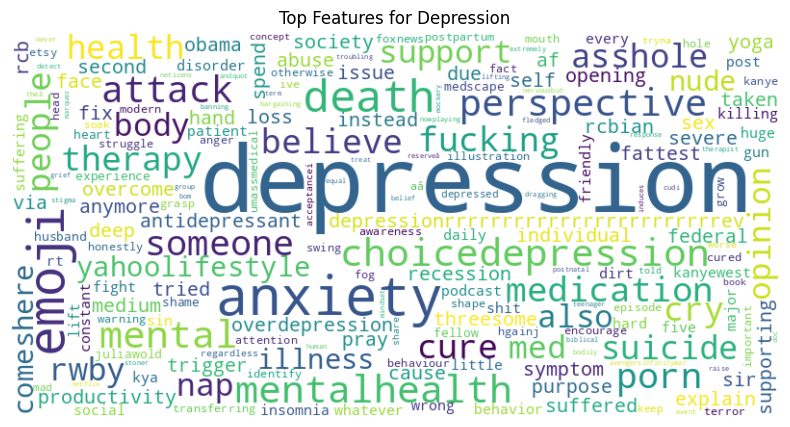


Cross-validation accuracy: [0.98625    0.98873592 0.98998748 0.98873592]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       487
           1       1.00      0.95      0.98       153

    accuracy                           0.99       640
   macro avg       0.99      0.98      0.98       640
weighted avg       0.99      0.99      0.99       640



In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

def process_and_train(dataset_file):
    corpus_df = pd.read_csv(dataset_file, header=None)
    # extracting features (text data) and labels
    X = corpus_df[0].tolist() # text data
    y = corpus_df[1].tolist() # labels

    X_preprocessed = [preprocess_text(post) for post in X]

    vectorizer = TfidfVectorizer()
    X_tfidf = vectorizer.fit_transform(X_preprocessed)

    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    # baseline model
    baseline_classifier = DummyClassifier(strategy="most_frequent")
    baseline_classifier.fit(X_train, y_train)
    baseline_accuracy = baseline_classifier.score(X_test, y_test)

    print("Baseline accuracy:", baseline_accuracy)

    svm_classifier = SVC(kernel="linear")
    svm_classifier.fit(X_train, y_train)

    coefficients = svm_classifier.coef_
    feature_names = vectorizer.get_feature_names_out()

    generate_word_cloud(coefficients, feature_names, "Top Features for Depression")

    skf = StratifiedKFold(n_splits=4)
    model = SVC(kernel="linear", class_weight="balanced")
    scores = cross_val_score(model, X_tfidf, y, cv=skf)

    print("\nCross-validation accuracy:", scores)
    print()

    y_pred = svm_classifier.predict(X_test)
    print(classification_report(y_test, y_pred))

def generate_word_cloud(coefficients, feature_names, title):
    feature_coefficients = {feature_names[i]: coefficients[0, i] for i in range(len(feature_names))}
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(feature_coefficients)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

process_and_train("mixedsvmlabels.csv")
process_and_train("twitterF.csv")
process_and_train("redditF.csv")

# Training on Reddit and testing on Twitter

Baseline accuracy: 0.49986852484880356



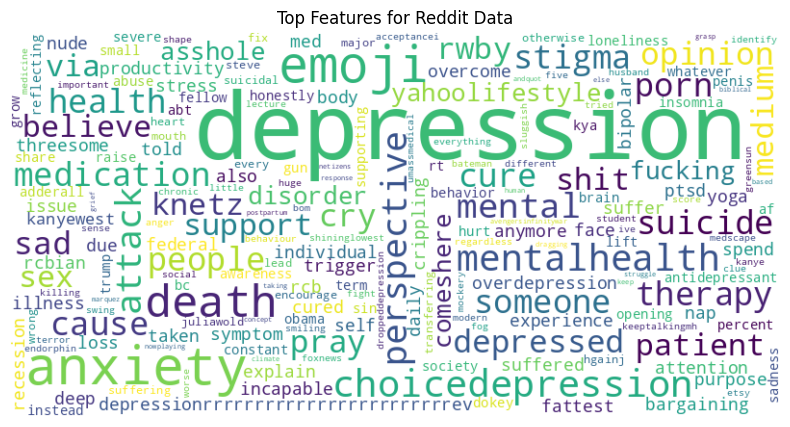

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1901
           1       1.00      0.45      0.62      1902

    accuracy                           0.72      3803
   macro avg       0.82      0.72      0.70      3803
weighted avg       0.82      0.72      0.70      3803



In [ ]:
def process_and_train(train_dataset_file, test_dataset_file):
    # loading train
    train_corpus_df = pd.read_csv(train_dataset_file, header=None)
    X_train = train_corpus_df[0].tolist()
    y_train = train_corpus_df[1].tolist()

    # loading test
    test_corpus_df = pd.read_csv(test_dataset_file, header=None)
    X_test = test_corpus_df[0].tolist()
    y_test = test_corpus_df[1].tolist()

    X_train_preprocessed = [preprocess_text(post) for post in X_train]
    X_test_preprocessed = [preprocess_text(post) for post in X_test]

    # TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train_preprocessed)
    X_test_tfidf = vectorizer.transform(X_test_preprocessed)

    # training svm
    svm_classifier = SVC(kernel="linear")
    svm_classifier.fit(X_train_tfidf, y_train)

    # baseline
    baseline_classifier = DummyClassifier(strategy="most_frequent")
    baseline_classifier.fit(X_train_tfidf, y_train)
    baseline_accuracy = baseline_classifier.score(X_test_tfidf, y_test)
    print("Baseline accuracy:", baseline_accuracy)
    print()

    # wordcloud
    coefficients = svm_classifier.coef_
    feature_names = vectorizer.get_feature_names_out()
    generate_word_cloud(coefficients, feature_names, "Top Features for Reddit Data")

    # eval
    y_pred = svm_classifier.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))



process_and_train("redditF.csv", "twitterF.csv")

# the model performs well in predicting class 0 (with high precision and recall), (72%)
# it struggles with class 1, particularly in terms of recall.
# the model may have difficulty correctly identifying instances of class 1 in the twitter dataset when trained on reddit data.
# Could this be due to differences in language use, topics, or user behaviors between the two platforms? This supports my idea that
# twitter and reddit data are EXPECTED to be different.

# Empath Categories

Baseline accuracy: 0.6285714285714286



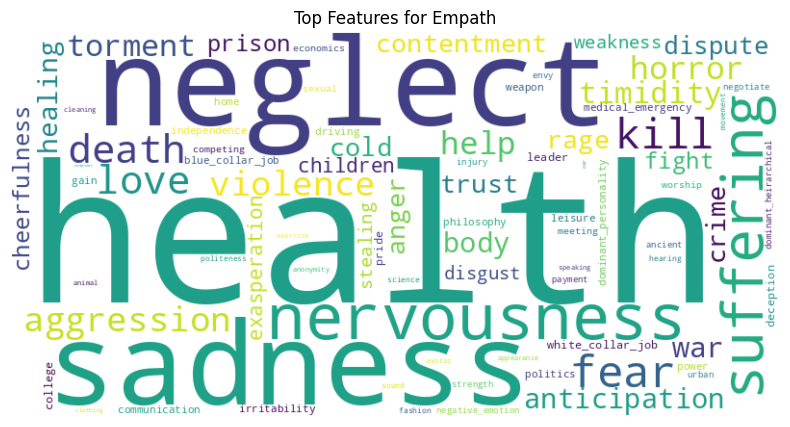

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       880
           1       0.93      0.52      0.67       520

    accuracy                           0.81      1400
   macro avg       0.85      0.75      0.76      1400
weighted avg       0.83      0.81      0.79      1400

Baseline accuracy: 0.4914586070959264



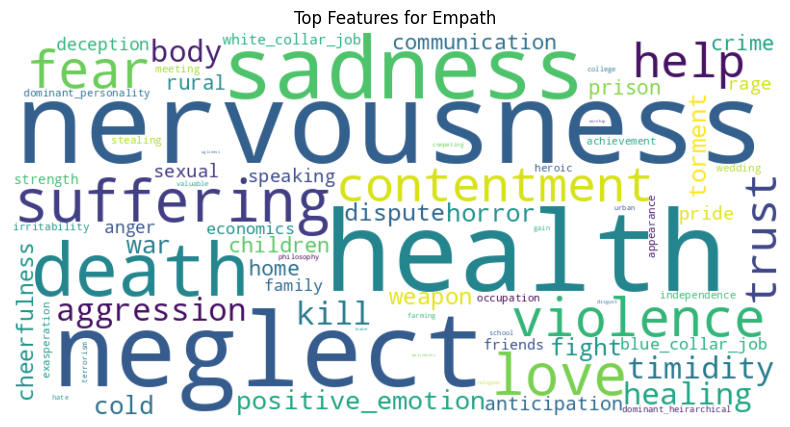

              precision    recall  f1-score   support

           0       0.66      0.89      0.75       374
           1       0.83      0.55      0.66       387

    accuracy                           0.72       761
   macro avg       0.74      0.72      0.71       761
weighted avg       0.75      0.72      0.71       761

Baseline accuracy: 0.7609375



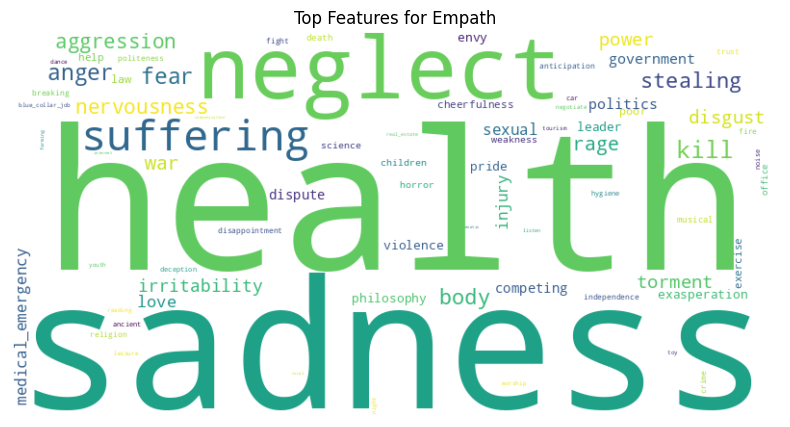

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       487
           1       0.97      0.69      0.80       153

    accuracy                           0.92       640
   macro avg       0.94      0.84      0.88       640
weighted avg       0.92      0.92      0.92       640



In [ ]:
lexicon = Empath()

def preprocess_text(text):
    tokens = text.split()
    tokens = [token.lower() for token in tokens if token.isalpha()]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

def generate_word_cloud(coefficients, feature_names, title):
    feature_coefficients = {feature_names[i]: coefficients[0, i] for i in range(len(feature_names))}
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(feature_coefficients)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

def process_and_train(dataset_file):
    corpus_df = pd.read_csv(dataset_file, header=None)
    X = corpus_df[0].tolist()  # text data
    y = corpus_df[1].tolist()  # labels

    X_preprocessed = [preprocess_text(post) for post in X]

    # Empath categories extraction
    empath_categories = []
    for text in X_preprocessed:
        categories = lexicon.analyze(text, normalize=True)
        if categories is not None:
            empath_categories.append(categories)
        else:
            empath_categories.append({})

    # vectorizing Empath categories
    vectorizer = DictVectorizer()
    X_empath = vectorizer.fit_transform(empath_categories)

    X_train, X_test, y_train, y_test = train_test_split(X_empath, y, test_size=0.2, random_state=42)

    # baseline
    baseline_classifier = DummyClassifier(strategy="most_frequent")
    baseline_classifier.fit(X_train, y_train)
    baseline_accuracy = baseline_classifier.score(X_test, y_test)
    print("Baseline accuracy:", baseline_accuracy)
    print()

    svm_classifier = SVC(kernel="linear")
    svm_classifier.fit(X_train, y_train)

    # word cloud
    coefficients = svm_classifier.coef_
    feature_names = vectorizer.get_feature_names_out()
    generate_word_cloud(coefficients, feature_names, "Top Features for Empath")

    # eval
    y_pred = svm_classifier.predict(X_test)
    print(classification_report(y_test, y_pred))

process_and_train("mixedsvmlabels.csv")
process_and_train("twitterF.csv")
process_and_train("redditF.csv")